In [211]:
from astropy.table import Table
from gen_dataset import *
import glob
from filters import filter_data, filters
import matplotlib.pyplot as plt
import numpy as np

filer_names = [name for name, _ in filters]

In [212]:
list_sed_templ = glob.glob('/data/kirg/MMVAE/SED_BPZ/*.sed')
print(list_sed_templ)

['/data/kirg/MMVAE/SED_BPZ/SB3_B2004a.sed', '/data/kirg/MMVAE/SED_BPZ/El_B2004a.sed', '/data/kirg/MMVAE/SED_BPZ/Im_B2004a.sed', '/data/kirg/MMVAE/SED_BPZ/Sbc_B2004a.sed', '/data/kirg/MMVAE/SED_BPZ/ssp_5Myr_z008.sed', '/data/kirg/MMVAE/SED_BPZ/Scd_B2004a.sed', '/data/kirg/MMVAE/SED_BPZ/ssp_25Myr_z008.sed', '/data/kirg/MMVAE/SED_BPZ/SB2_B2004a.sed']


In [214]:
spectra_list = [] 
wavelengths_list = []
param_list = []

z_range = np.random.uniform(size=100)
for i, fl in enumerate(list_sed_templ):
    t = Table.read(fl, format='ascii.no_header')
    wl = t['col1']
    for z in z_range:
        wavelengths_list.append(wl * (1 + z))
        spectra_list.append(t['col2'] * wl**2)
        param_list.append([z])

In [215]:
n_augmentations = 10
normalize_spectra = True


perturbation_sigmas = [0.1] * 5

photocalc = PhotometricCalculator(spec_range=(3900, 10200), spec_points=100, filter_data=filter_data)

photometry, (binned_spectra, _) = photocalc.calculate_flux_and_mag(
            spectra_list, wavelengths_list, list(photocalc.filter_data.keys())
        )


output_array = [[[entry[1] for entry in mag], params, spec]
                for mag, params, spec in zip(photometry, param_list, binned_spectra)]

output_array = [[[float(v) for v in flux], [float(p[0])], spec]
                for flux, p, spec in output_array]

dataset = []
for flux_list, params, spec in output_array:
    for _ in range(n_augmentations):
        flux_arr = np.array(flux_list)
        if normalize_spectra:
            flux_arr /= np.max(flux_arr)
        perturbed = [
            val + sigma * np.random.normal(0, 1) * val
            for val, sigma in zip(flux_arr, perturbation_sigmas)
        ]
        spectrum_norm = spec / np.max(spec) if normalize_spectra else spec
        dataset.append([perturbed, params, spectrum_norm])

integrals = np.array([entry[0] for entry in dataset])
params = np.array([entry[1] for entry in dataset])
spectra = np.array([entry[2] for entry in dataset])



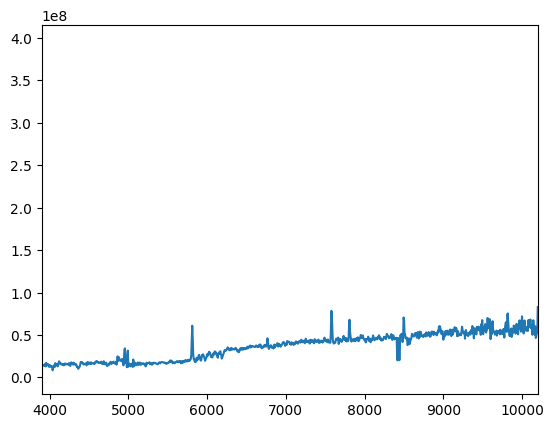

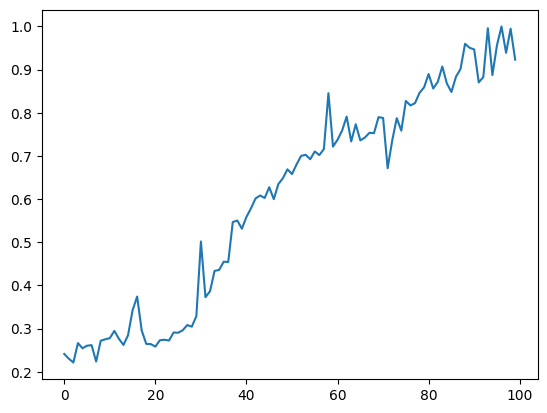

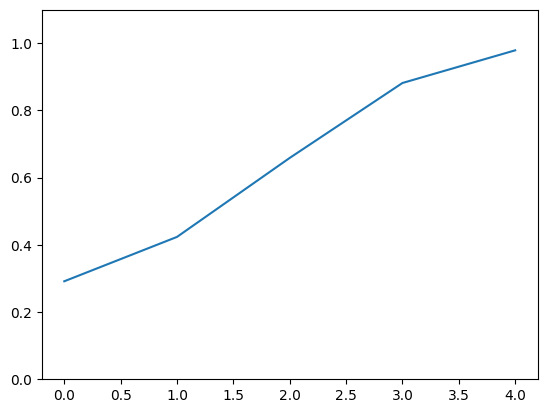

In [216]:
plt.plot(wavelengths_list[0], spectra_list[0])
plt.xlim(3900, 10200)
plt.show()

plt.plot(spectra[0])
plt.show()


plt.plot(integrals[0])
plt.ylim(0, 1.1)
plt.show()

In [217]:
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')
     

hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.0) & (t_hsc_['z'] < 2.0))]


36.79882747308769 -1.4077911223514967 0.2573077224876036
[20.561226 20.004028 19.870544 19.72671  19.67862 ]
Min err:  0.017979485004496518


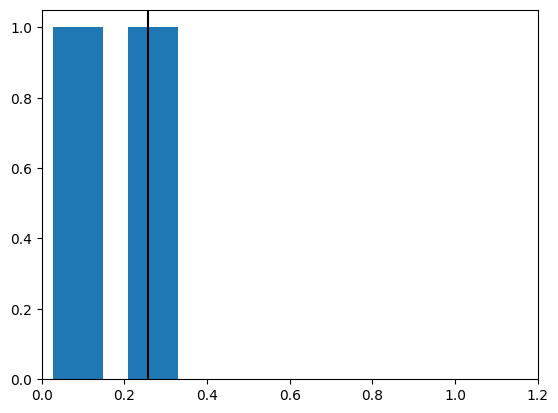

In [218]:
target_id = 39627749106648831

r = t_hsc[t_hsc['targetid'] == target_id][0]

print(r['ra'], r['dec'], r['z'])

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
print(mags)
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

rall = np.sum((integrals[:, :] - bandfl[:])**2, axis=-1)
print('Min err: ', np.sqrt(np.min(rall) / 5.0))

idx = np.where(rall < 5*0.033**2)[0]

p_v = params[idx]

plt.hist(p_v[:, 0])
plt.xlim(0, 1.2)
plt.axvline(r['z'], color='black')
plt.show()
